#HomeWork 08 : Campaign Response Model

Pisut Sukpool 6210422044

# **Importing libraries and datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/BADS_NIDA/CRM/hw8_campaign_response/'

In [134]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import  ExtraTreesClassifier
from sklearn.ensemble import  GradientBoostingClassifier


from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random_state=99

In [4]:
df_response = pd.read_csv(path+'Retail_Data_Response.csv')
df_transactions = pd.read_csv(path+'Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [5]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [6]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


# **Data Preparation & Feature Engineering**

In [84]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


In [85]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

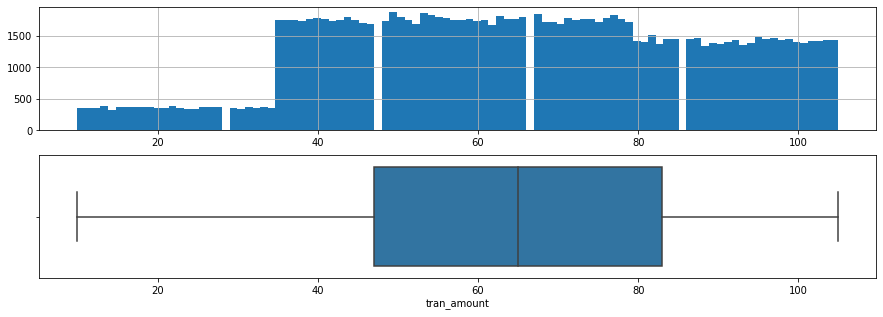

In [86]:
fig, axes = plt.subplots(2,1, figsize=(15,5))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

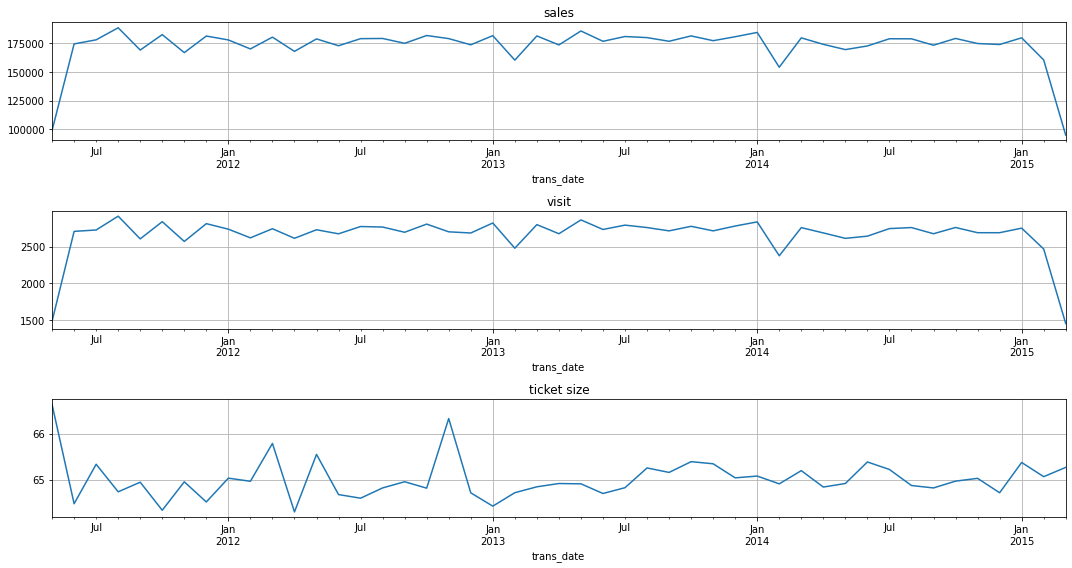

In [87]:
fig, axes = plt.subplots(3,1, figsize=(15,8), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='visit', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].apply(lambda x: x.sum()/x.count()).plot(title='ticket size')
for ax in axes:
    ax.grid(True)

plt.show()

In [88]:
campaign_date = dt.datetime(2015,3,17)

df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['is_weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head()

,customer_id,trans_date,tran_amount,age,is_weekend
77247,CS1112,2011-06-15,56,1371,False
89149,CS1112,2011-08-19,96,1306,False
68206,CS1112,2011-10-02,60,1262,True
36486,CS1112,2012-04-08,56,1073,True
93074,CS1112,2012-06-24,52,996,True


In [177]:
df = df_transactions.groupby('customer_id').agg(
        recency=('age', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        length_of_stay=('age', lambda x: x.max() - x.min()),
     )


#Customer Movement
df_movement =  df_transactions[['customer_id','trans_date']]
df_movement['date_lag'] = df_movement.groupby(['customer_id'])['trans_date'].shift(1)
df_movement['date_lead'] = df_movement.groupby(['customer_id'])['trans_date'].shift(-1)
df_movement['date_diff'] = (df_movement['trans_date'] - df_movement['date_lag']).dt.days

conditions_active_1_month = [
    (df_movement['date_diff'] <= 30),
    (df_movement['date_diff'] > 30)
    ]
values_active_1_month = ['Repeat', 'Reactivated']
df_movement['Movement_active_1m'] = np.select(conditions_active_1_month, values_active_1_month)

conditions_active_2_month = [
    (df_movement['date_diff'] <= 60),
    (df_movement['date_diff'] > 60)
    ]
values_active_2_month = ['Repeat', 'Reactivated']
df_movement['Movement_active_2m'] = np.select(conditions_active_2_month, values_active_2_month)

conditions_active_3_month = [
    (df_movement['date_diff'] <= 90),
    (df_movement['date_diff'] > 90)
    ]   
values_active_3_month = ['Repeat', 'Reactivated']
df_movement['Movement_active_3m'] = np.select(conditions_active_3_month, values_active_3_month)
df_movement.loc[df_movement['Movement_active_1m'] == '0', 'Movement_active_1m'] = 'New'
df_movement.loc[df_movement['Movement_active_2m'] == '0', 'Movement_active_2m'] = 'New'
df_movement.loc[df_movement['Movement_active_3m'] == '0', 'Movement_active_3m'] = 'New'
#filter = df_movement['customer_id']=='CS1112' 
#df_movement.where(filter, inplace = True)

df_movement_1m =  df_movement[['customer_id','trans_date','Movement_active_1m']]
df_movement_2m =  df_movement[['customer_id','trans_date','Movement_active_2m']]
df_movement_3m =  df_movement[['customer_id','trans_date','Movement_active_3m']]

df_movement_1m=df_movement_1m.pivot_table(index='customer_id',columns='Movement_active_1m',values='trans_date',aggfunc='count',fill_value=0).add_suffix('_active_1m')
df_movement_2m=df_movement_2m.pivot_table(index='customer_id',columns='Movement_active_2m',values='trans_date',aggfunc='count',fill_value=0).add_suffix('_active_2m')
df_movement_3m=df_movement_3m.pivot_table(index='customer_id',columns='Movement_active_3m',values='trans_date',aggfunc='count',fill_value=0).add_suffix('_active_3m')


df_movement_1m.columns.name = None    
df_movement_1m = df_movement_1m.reset_index()  
df_movement_2m.columns.name = None    
df_movement_2m = df_movement_2m.reset_index()  
df_movement_3m.columns.name = None    
df_movement_3m = df_movement_3m.reset_index()  

df_movement_1m = df_movement_1m[['customer_id','Reactivated_active_1m','Repeat_active_1m']]
df_movement_2m = df_movement_2m[['customer_id','Reactivated_active_2m','Repeat_active_2m']]
df_movement_3m = df_movement_3m[['customer_id','Reactivated_active_3m','Repeat_active_3m']]


# weekend
weekend_df = df_transactions.groupby(['customer_id','is_weekend'])['tran_amount'].agg(['size','sum','mean']).unstack(fill_value=0)
weekend_df.columns = ['visit_weekday','visit_weekend','spend_weekday','spend_weekend','ticket_size_weekday','ticket_size_weekend']
df = df.join(weekend_df)


df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad'),
    
))

# time to event
event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# RFM with Time to event
periods = [6, 12, 18, 24]
for n in periods:
    window_df = df_transactions[df_transactions.trans_date > df_transactions.trans_date.max() - relativedelta(months=n)]

    df = df.join(window_df.groupby('customer_id')['tran_amount'].agg(
        [ (f'monetary_{n}m','sum'), (f'frequency_{n}m', 'size'), 
        (f'avg_spend_{n}m', 'mean'), (f'std_spend_{n}m', 'std'),
         (f'iqr_spend_{n}m', lambda x: x.quantile(0.75) - x.quantile(0.25))]
    ))

    event_df = window_df.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
    event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
    event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days
    df = df.join(event_df.groupby('customer_id')['duration'].agg(
        [ (f'avg_dur_{n}m', 'mean'), (f'std_dur_{n}m', 'std'), 
         (f'iqr_dur_{n}m', lambda x: x.quantile(.75) - x.quantile(.25)),
         (f'num_repeat_{n}m', 'count')
         ]
    ))


df = df_movement_1m.set_index('customer_id').join(df)
df = df_movement_2m.set_index('customer_id').join(df)
df = df_movement_3m.set_index('customer_id').join(df)


df.fillna(0, inplace=True)
df = df.dropna(axis=0, subset=['recency']) ###
df = df_response.set_index('customer_id').join(df)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,response,Reactivated_active_3m,Repeat_active_3m,Reactivated_active_2m,Repeat_active_2m,Reactivated_active_1m,Repeat_active_1m,recency,frequency,monetary,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,5,9,11,3,13,1,62,15,1012,1309,10,5,696,316,69.600000,63.200000,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0
CS1113,0,5,14,8,11,14,5,36,20,1490,1354,17,3,1296,194,76.235294,64.666667,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0
CS1114,1,7,11,8,10,10,8,33,19,1432,1309,13,6,955,477,73.461538,79.500000,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0
CS1115,1,3,18,9,12,14,7,12,22,1659,1303,16,6,1183,476,73.937500,79.333333,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0
CS1116,1,4,8,6,6,8,4,204,13,857,1155,12,1,797,60,66.416667,60.000000,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0


In [178]:
df = df.dropna(axis=0, subset=['recency'])
df.to_excel('prep_data.xlsx')

## **Calculating response rate**

In [179]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


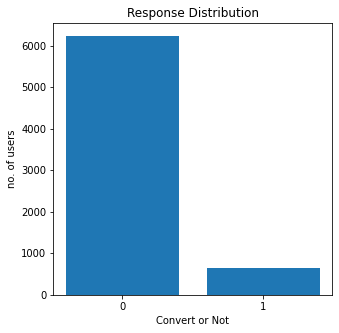

In [180]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

# **Creating train and test dataset**

In [181]:
## spliting dataframe into X and y

X = df.drop(columns=['response'])
y = df['response']

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 60)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 60)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

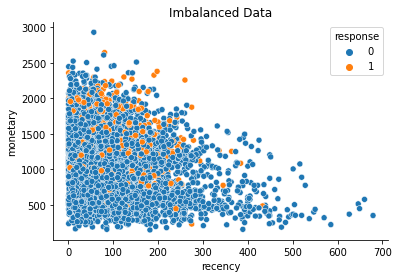

In [183]:
sns.scatterplot(data=df, x='recency', y='monetary', hue='response')
sns.despine()
plt.title("Imbalanced Data")

# **Fixing imbalanced with Undersampling**

[0.36659961 0.09384789]


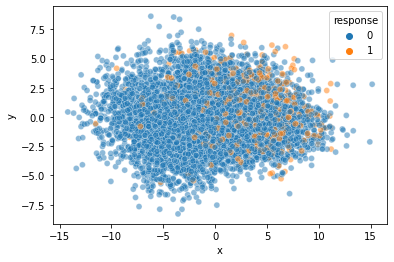

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.drop(['response'],axis=1)
X_std = scale(X)

pca = PCA(2)
embed = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
sns.scatterplot(data=pd.DataFrame({'x':embed[:,0],'y':embed[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5);

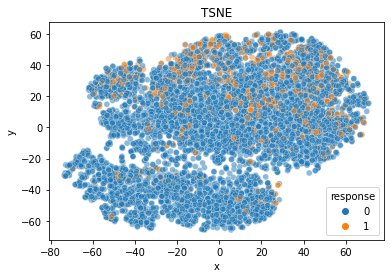

In [97]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(2).fit_transform(X_std)
sns.scatterplot(data=pd.DataFrame({'x':embed_tsne[:,0],'y':embed_tsne[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5)
plt.title('TSNE');

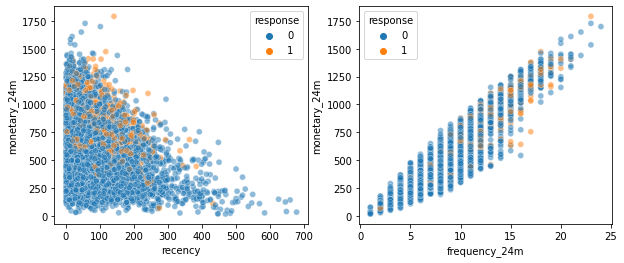

In [98]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='frequency_24m', y='monetary_24m', hue='response', alpha=.5, ax=axes[1])
plt.show()

# **Feature Selection**

In [185]:
adb_selector = SelectFromModel(AdaBoostClassifier(n_estimators=500, random_state=random_state), max_features=30)
et_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=500, random_state=random_state), max_features=30)
gb_selector = SelectFromModel(GradientBoostingClassifier(n_estimators=500, random_state=random_state), max_features=30)
rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=500, random_state=random_state), max_features=30)

adb_selector.fit(X, y)
et_selector.fit(X, y)
gb_selector.fit(X, y)
rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500, n_jobs=None,
                                                 oob_score=False,

In [186]:
adb_support = adb_selector.get_support()
adb_feature = X.loc[:,adb_support].columns.tolist()

et_support = et_selector.get_support()
et_feature = X.loc[:,et_support].columns.tolist()

gb_support = gb_selector.get_support()
gb_feature = X.loc[:,gb_support].columns.tolist()

rf_support = rf_selector.get_support()
rf_feature = X.loc[:,rf_support].columns.tolist()

sum_feature = adb_feature + et_feature + gb_feature + rf_feature

from collections import Counter

group_feature = dict(Counter(sum_feature))

filter_group_feature = { key: value for key, value in group_feature.items() if value > 2 }
filter_group_feature

{'avg_dur_12m': 3,
 'avg_dur_18m': 4,
 'avg_dur_24m': 4,
 'avg_duration': 4,
 'avg_spend_18m': 4,
 'frequency_24m': 3,
 'iqr_dur_24m': 4,
 'length_of_stay': 3,
 'mad_ticket_size': 3,
 'med_ticket_size': 3,
 'monetary_12m': 4,
 'monetary_18m': 4,
 'monetary_24m': 4,
 'recency': 4,
 'spend_weekday': 3,
 'spend_weekend': 3,
 'std_dur_18m': 4,
 'std_dur_24m': 4,
 'std_spend_24m': 3,
 'std_ticket_size': 4,
 'ticket_size': 3,
 'ticket_size_weekday': 3}

In [187]:
filter_feature =  [ i for i in filter_group_feature]
filter_feature

['recency',
 'length_of_stay',
 'spend_weekday',
 'spend_weekend',
 'ticket_size_weekday',
 'ticket_size',
 'std_ticket_size',
 'med_ticket_size',
 'avg_duration',
 'monetary_12m',
 'monetary_18m',
 'avg_spend_18m',
 'avg_dur_18m',
 'std_dur_18m',
 'monetary_24m',
 'std_spend_24m',
 'avg_dur_24m',
 'std_dur_24m',
 'iqr_dur_24m',
 'mad_ticket_size',
 'avg_dur_12m',
 'frequency_24m']

# **Evaluation**

In [188]:
undersampler = RandomUnderSampler(random_state=random_state)
oversampler = RandomOverSampler(random_state=random_state)
smote = SMOTE(random_state=random_state)
smote_tomek = SMOTETomek(random_state=random_state)
smote_enn = SMOTEENN(random_state=random_state)
smote_borderline = BorderlineSMOTE(random_state=random_state)
smote_svm = SVMSMOTE(random_state=random_state)
adasyn = ADASYN(random_state=random_state)

resamplers = [('no resampler', None),('undersampler', undersampler),('oversampler', oversampler),
                     ('smote', smote),('smote_tomek', smote_tomek),('smote_enn', smote_enn),        
                     ('smote_borderline', smote_borderline),('smote_svm', smote_svm),('adasyn', adasyn),
                    ] 

kf = StratifiedKFold(n_splits=10)

metric_cols = ['model','resampler','train-scores-mean','train-scores-std','val-scores-mean','val-scores-std','test']

def get_resample(x, y, resampler=None):
    if resampler:
        x_rs, y_rs = resampler.fit_resample(x, y)
        x_rs = pd.DataFrame(x_rs, columns=x.columns) 
        y_rs = pd.Series(y_rs, name=y.name)
    else:
        x_rs, y_rs = x, y
    return x_rs, y_rs

test_size = 0.3
valid_size = 0.2

X = df[filter_feature].copy()
y = df['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size= valid_size/(1-test_size),random_state=55, stratify=y_train)  

## **Logistics Regression**

In [189]:
model_name = 'LogisticRegression'
logreg_params = {'solver': 'liblinear','class_weight': 'balanced','random_state': random_state,}
def logreg_cross_val_score(params,  cv, resampler=None):
    train_scores = []
    val_scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]
        X_train_rs, y_train_rs = get_resample(X_train_fold, y_train_fold, resampler)
        model = LogisticRegression(**params)
        model.fit(X_train_rs, y_train_rs)
        auc_train = roc_auc_score(y_train_rs, model.decision_function(X_train_rs))
        auc_val = roc_auc_score(y_val_fold, model.decision_function(X_val_fold))
        train_scores.append(auc_train)
        val_scores.append(auc_val)
    return train_scores, val_scores
def logreg_eval_score(params, resampler=None):
    X_train_rs, y_train_rs = get_resample(X_train2, y_train2, resampler)
    model = LogisticRegression(**params)
    model.fit(X_train_rs, y_train_rs)
    auc_train = roc_auc_score(y_train_rs, model.decision_function(X_train_rs))
    auc_val = roc_auc_score(y_val, model.decision_function(X_val))
    auc_test = roc_auc_score(y_test, model.decision_function(X_test))
    return auc_train, auc_val, auc_test
result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = logreg_cross_val_score(logreg_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = logreg_eval_score(logreg_params, resampler=rs)
    result.append((model_name, rs_name, np.mean(train_scores), np.std(train_scores),np.mean(val_scores), np.std(val_scores),auc_test))
df_logreg_eval = pd.DataFrame(result, columns=metric_cols)
df_logreg_eval

,model,resampler,train-scores-mean,train-scores-std,val-scores-mean,val-scores-std,test
0,LogisticRegression,no resampler,0.783660,0.002446,0.768700,0.024894,0.807764
1,LogisticRegression,undersampler,0.778264,0.007359,0.764724,0.025142,0.800671
2,LogisticRegression,oversampler,0.781628,0.002536,0.767260,0.024700,0.806409
3,LogisticRegression,smote,0.784759,0.002839,0.765671,0.026362,0.803072
4,LogisticRegression,smote_tomek,0.785992,0.002833,0.765532,0.025865,0.803333
5,LogisticRegression,smote_enn,0.873127,0.004230,0.769680,0.024020,0.807475
6,LogisticRegression,smote_borderline,0.826041,0.004631,0.769484,0.024230,0.803433
7,LogisticRegression,smote_svm,0.873836,0.010852,0.763195,0.026589,0.795255
8,LogisticRegression,adasyn,0.777601,0.002865,0.764506,0.026589,0.798099


## **XGBoost**

In [190]:
model_name = 'XGBoost'
xgb_params = {'objective':'binary:logistic', 'random_state':random_state, 'eval_metric':'auc','colsample_bytree': 0.65, 'learning_rate': 0.03, 'max_depth': 3, 'reg_alpha': 21, 'reg_lambda':12,'gamma':1,'n_estomators':500, }
fit_params={'early_stopping_rounds': 10, 'eval_metric': 'auc', 'verbose': False, }

def xgb_cross_val_score(params, cv, resampler=None):    
    train_scores = []
    val_scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]
        X_train_rs, y_train_rs = get_resample(X_train_fold, y_train_fold, resampler)
        scale_pos_weight = (len(y_train_rs) - sum(y_train_rs)) / sum(y_train_rs)
        eval_set=[(X_train_rs, y_train_rs), (X_val_fold, y_val_fold)]
        model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **params)
        model = model.fit(X_train_rs, y_train_rs, eval_set=eval_set,
                          early_stopping_rounds=50, eval_metric='auc', verbose=False)
        auc_train = roc_auc_score(y_train_rs, model.predict_proba(X_train_rs)[:,1])
        auc_val = roc_auc_score(y_val_fold, model.predict_proba(X_val_fold)[:,1])
        train_scores.append(auc_train)
        val_scores.append(auc_val)
    return train_scores, val_scores
def xgb_eval_score(params, resampler=None):
    X_train_rs, y_train_rs = get_resample(X_train2, y_train2, resampler)
    scale_pos_weight = (len(y_train_rs) - sum(y_train_rs)) / sum(y_train_rs)
    eval_set=[(X_train_rs, y_train_rs), (X_val, y_val)]
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, **params)
    model = model.fit(X_train_rs, y_train_rs, eval_set=eval_set,
                        early_stopping_rounds=50, eval_metric='auc', verbose=False)
    auc_train = roc_auc_score(y_train_rs, model.predict_proba(X_train_rs)[:,1])
    auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return auc_train, auc_val, auc_test
result = []
for rs_name, rs in resamplers:
    train_scores, val_scores = xgb_cross_val_score(xgb_params, resampler=rs, cv=kf)
    auc_train, auc_val, auc_test = xgb_eval_score(xgb_params, resampler=rs)
    result.append((model_name, rs_name, np.mean(train_scores), np.std(train_scores),np.mean(val_scores), np.std(val_scores),auc_test))
df_xgb_eval = pd.DataFrame(result, columns=metric_cols)
df_xgb_eval

,model,resampler,train-scores-mean,train-scores-std,val-scores-mean,val-scores-std,test
0,XGBoost,no resampler,0.819239,0.016996,0.793559,0.025672,0.809547
1,XGBoost,undersampler,0.803592,0.014577,0.779146,0.024116,0.794921
2,XGBoost,oversampler,0.820798,0.013223,0.790818,0.025317,0.817286
3,XGBoost,smote,0.838837,0.018077,0.790024,0.024544,0.801208
4,XGBoost,smote_tomek,0.839061,0.018268,0.789385,0.023790,0.798150
5,XGBoost,smote_enn,0.912302,0.009041,0.788400,0.023414,0.815539
6,XGBoost,smote_borderline,0.873421,0.015846,0.785869,0.025868,0.798359
7,XGBoost,smote_svm,0.923644,0.012579,0.782309,0.023010,0.800207
8,XGBoost,adasyn,0.834816,0.020584,0.790574,0.024457,0.797460
